# Tutorial #6: Monte Carlo Predictive Coding

In this notebook we will see how to create and train a simple MCPC model to learn a Gaussian data distribution.

In [69]:
from typing import Callable

# These are the default import names used in tutorials and documentation.
import jax
import jax.tree_util as jtu
import jax.numpy as jnp
import equinox as eqx
from optax._src import base 
from optax._src import combine
from optax._src import transform
from typing import Any, Callable, Optional, Union
import ot
import numpy as np


import pcax as px
import pcax.predictive_coding as pxc
import pcax.nn as pxnn
import pcax.functional as pxf
import pcax.utils as pxu

px.RKG.seed(42)
np.random.seed(42)

In [70]:
class Model(pxc.EnergyModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        nm_layers: int,
        act_fn: Callable[[jax.Array], jax.Array],
        input_var = 1.0
    ) -> None:
        super().__init__()

        def se_energy_input(vode, rkg: px.RandomKeyGenerator = px.RKG):
            """Squared error energy function derived from a Gaussian distribution."""
            e = vode.get("h") - vode.get("u")
            return 0.5 * (e * e)/input_var


        self.act_fn = px.static(act_fn)
        
        self.layers = [pxnn.Linear(input_dim, hidden_dim)] + [
            pxnn.Linear(hidden_dim, hidden_dim) for _ in range(nm_layers - 2)
        ] + [pxnn.Linear(hidden_dim, output_dim)]

        self.vodes = [
            pxc.Vode((hidden_dim,)) for _ in range(nm_layers-1)
        ] + [pxc.Vode((output_dim,), se_energy_input)]
        
        
        self.vodes[-1].h.frozen = True

    def __call__(self, x, y):
        for v, l in zip(self.vodes, self.layers):
            x = v(l(self.act_fn(x)))

        # x = self.vodes[-1](self.layers[-1](x))

        if y is not None:
            self.vodes[-1].set("h", y)
        return self.vodes[-1].get("u")

In [71]:
@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0, 0), out_axes=0)
def forward(x, y, *, model: Model):
    return model(x, y)

@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0,), out_axes=(None, 0), axis_name="batch")
def energy(x, *, model: Model):
    y_ = model(x, None)
    return jax.lax.psum(model.energy().sum(), "batch"), y_

In [72]:
@pxf.jit(static_argnums=0)
def train_on_batch(
    T: int,
    x: jax.Array,
    y: jax.Array,
    *,
    model: Model,
    optim_w: pxu.Optim,
    optim_h: pxu.Optim
):
    def h_step(i, x, *, model, optim_h):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, y_), g = pxf.value_and_grad(
                pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(x, model=model)
        optim_h.step(model, g["model"])
        return x, None

    print("Training!")
    model.train()
    
    # Init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model)
    
    # Inference steps
    pxf.scan(h_step, xs=jax.numpy.arange(T))(x, model=model, optim_h=optim_h)

    # Learning step
    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        (e, y_), g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(x, model=model)
    optim_w.step(model, g["model"])


from tqdm import tqdm
def train(dl, T, *, model: Model, optim_w: pxu.Optim, optim_h: pxu.Optim):
    model.vodes[-1].h.frozen = True
    for x, y in tqdm(dl):
        train_on_batch(T, x, y, model=model, optim_w=optim_w, optim_h=optim_h)

In [73]:
import numpy as np
from scipy.stats import wasserstein_distance

@pxf.jit(static_argnums=0)
def eval_on_batch(
    T: int,
    x: jax.Array, 
    *, 
    model: Model,
    optim_h: pxu.Optim
    ):
    def h_step(i, x, *, model, optim_h):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, y_), g = pxf.value_and_grad(
                pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(x, model=model)
        optim_h.step(model, g["model"])
        return x, None

    print("Evaluation!")  
    model.train()

    if model.vodes[-1].h.frozen:
        print("vode[-1] should not be frozen! set frozen=False before calling eval function.")

    # Init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, None, model=model)
    
    # Inference steps
    x, y_ = pxf.scan(h_step, xs=jax.numpy.arange(T))(x, model=model, optim_h=optim_h)

# MCPC evaluation loop for 1D data
def eval(dl, T, *, model: Model, optim_h: pxu.Optim):
    model.vodes[-1].h.frozen = False
    ys = []
    ys_ = []
    
    for x, y in dl:
        eval_on_batch(T, x, model=model, optim_h=optim_h)
        ys.append(y)
        ys_.append(model.vodes[-1].get("h"))

    ys = np.concatenate(ys, axis=0)
    ys_ = np.concatenate(ys_, axis=0)

    a = np.ones(len(ys)) / len(ys)
    b = np.ones(len(ys_)) / len(ys_)
    M = ot.dist(ys, ys_)
    emd_distance = ot.emd2(a, b, M)
    return emd_distance, ys_

In [74]:
import optax

batch_size = 150

model = Model(
    input_dim=2,
    hidden_dim=2,
    output_dim=2,
    nm_layers=2,
    act_fn= lambda x:x
)

In [75]:
## define noisy sgd optimiser for MCPC
def sgdld(
    learning_rate: base.ScalarOrSchedule,
    momentum: Optional[float] = None,
    h_var: float = 1.0,
    gamma: float = 0.,
    nesterov: bool = False,
    accumulator_dtype: Optional[Any] = None,
    seed: int = 0
) -> base.GradientTransformation:
  eta = 2*h_var*(1-momentum)/learning_rate if momentum is not None else 2*h_var/learning_rate
  return combine.chain(
      transform.add_noise(eta, gamma, seed),
      (transform.trace(decay=momentum, nesterov=nesterov,
                       accumulator_dtype=accumulator_dtype)
       if momentum is not None else base.identity()),
      transform.scale_by_learning_rate(learning_rate)
  )

In [76]:
h_optimiser_fn = sgdld
lr = 1e-2
momentum = 0.0
h_var = 0.1
gamma = 0.
lr_p = 1e-3

with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jax.numpy.zeros((batch_size, 2)), None, model=model)
    optim_h = pxu.Optim(h_optimiser_fn(lr, momentum, h_var, gamma), pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True))(model))
    optim_w = pxu.Optim(optax.adam(lr_p), pxu.Mask(pxnn.LayerParam)(model))
    # make optimiser that also optimises the activity of the model layer[-1]
    model.vodes[-1].h.frozen = False
    forward(jax.numpy.zeros((batch_size, 2)), None, model=model)
    optim_h_eval = pxu.Optim(h_optimiser_fn(lr, momentum, h_var, gamma), pxu.Mask(pxu.m(pxc.VodeParam))(model))
    model.vodes[-1].h.frozen = True

Text(0, 0.5, 'petal length')

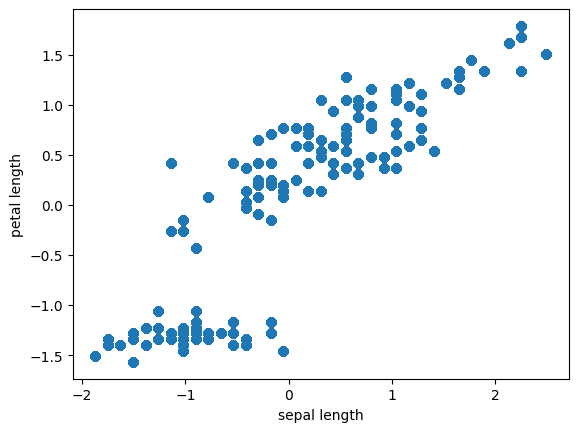

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
iris = load_iris()
y = iris.data

# keep only sepal length and petal length
y_data = y[:,(0,2)]
y_data = (y_data - y_data.mean(0)) / y_data.std(0)
n = len(y_data)

nm_elements = batch_size*n
X = np.zeros((batch_size * (nm_elements // batch_size), 2))
y = np.repeat(y_data, batch_size, axis=0)
np.random.shuffle(y)

if n % batch_size == 0:
    nm_elements_test = n
elif batch_size % n == 0:
    nm_elements_test = batch_size
else:
    raise NotImplementedError
X_test = np.zeros((batch_size * (nm_elements_test // batch_size), 2))
y_test = np.repeat(y_data, nm_elements_test // n, axis=0)


nm_elements_gen = n * 30  # 150 x 30
X_gen = np.zeros((batch_size * (nm_elements_gen // batch_size), 2))
y_gen = np.repeat(y_data, nm_elements_gen // n, axis=0)

plt.scatter(y[:,0], y[:,1])
plt.xlabel("sepal length")
plt.ylabel("petal length")

In [78]:
# we split the dataset in training batches and do the same for the generated test set.
train_dl = list(zip(X.reshape(-1, batch_size, 2), y.reshape(-1, batch_size, 2)))
test_dl = tuple(zip(X_test.reshape(-1, batch_size, 2), y_test.reshape(-1, batch_size, 2)))
gen_dl = tuple(zip(X_gen.reshape(-1, batch_size, 2), y_gen.reshape(-1, batch_size, 2)))

In [79]:
import random

nm_epochs = 5120 // (nm_elements // batch_size)

T = 150
T_eval = 10000
w, y_ = eval(test_dl, T = T_eval, model=model, optim_h=optim_h_eval)
print(f"Epoch {0}/{nm_epochs} - Wasserstein distance: {w :.2f}")
for e in range(nm_epochs):
    random.shuffle(train_dl)
    train(train_dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
    if e % 10 == 9:
        w, y_ = eval(test_dl, T = T_eval, model=model, optim_h=optim_h_eval)
        print(f"Epoch {e + 1}/{nm_epochs} - Wasserstein distance: {w :.2f}")

w, y_ = eval(gen_dl, T = T_eval, model=model, optim_h=optim_h_eval)
print(f"Epoch {e + 1}/{nm_epochs} - Wasserstein distance: {w :.2f}")

# print(f"Learned data distribution has mean {y_.mean():.2f} and var {y_.var():.2f} ")
print(f"Learned parameters weight {model.layers[-1].nn.weight.get()[0,0] :.2f} and bias {model.layers[0].nn.bias.get()[0] :.2f}")

Evaluation!
Epoch 0/34 - Wasserstein distance: 1.32


  0%|                                                                                                      | 0/150 [00:00<?, ?it/s]

Training!


100%|███████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 241.86it/s]


Epoch 5/34 - Wasserstein distance: 0.72


100%|███████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 239.43it/s]


Epoch 10/34 - Wasserstein distance: 0.46


100%|███████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 241.98it/s]


Epoch 15/34 - Wasserstein distance: 0.43


100%|███████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 241.55it/s]


Epoch 20/34 - Wasserstein distance: 0.26


100%|███████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 241.94it/s]


Epoch 25/34 - Wasserstein distance: 0.26


100%|███████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 241.74it/s]


Epoch 30/34 - Wasserstein distance: 0.26


100%|███████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 240.88it/s]


Epoch 34/34 - Wasserstein distance: 0.19
Learned parameters weight 2.10 and bias 0.27


/data/ndcn-computational-neuroscience/pemb6612/envs/pcax/lib/python3.10/site-packages/ot/lp/__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


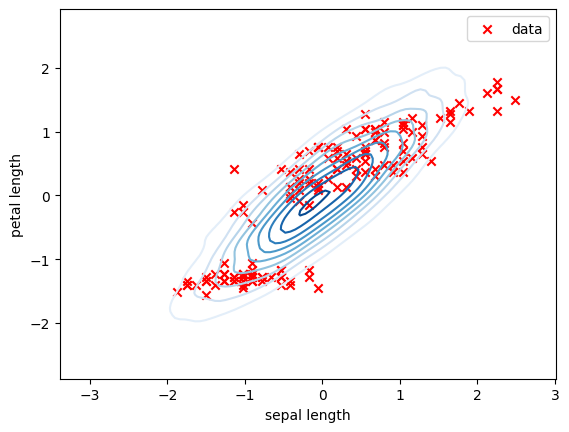

In [80]:
from scipy.stats import gaussian_kde

# Create a 2D Gaussian kernel density estimate
data = np.vstack(y_.transpose())
kde = gaussian_kde(data)
# Define grid points
x_grid = np.linspace(data[0].min(), data[0].max(), 100)
y_grid = np.linspace(data[1].min(), data[1].max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# Plot contour lines
plt.contour(X, Y, Z, levels=10, cmap='Blues')
plt.scatter(y_test[:,0], y_test[:,1], marker="x", color="r", label="data")
plt.xlabel("sepal length")
plt.ylabel("petal length")
plt.legend()

## Learn Non-linear multimodal distirbution

In [81]:
model_nn = Model(
    input_dim=2,
    hidden_dim=64,
    output_dim=2,
    nm_layers=3,
    act_fn=jax.nn.tanh,
    input_var = 0.01
)


h_optimiser_fn = sgdld
lr = 0.01
momentum = 0.9
h_var = 1.0
gamma = 0.
lr_p = 0.001

with pxu.step(model_nn, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jax.numpy.zeros((batch_size, 2)), None, model=model_nn)
    optim_h = pxu.Optim(h_optimiser_fn(lr, momentum, h_var, gamma), pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True))(model_nn))
    optim_w = pxu.Optim(optax.adamw(lr_p), pxu.Mask(pxnn.LayerParam)(model_nn))
    # make optimiser that also optimises the activity of the model layer[-1]
    model_nn.vodes[-1].h.frozen = False
    forward(jax.numpy.zeros((batch_size, 2)), None, model=model_nn)
    optim_h_eval = pxu.Optim(h_optimiser_fn(lr, momentum, h_var, gamma), pxu.Mask(pxu.m(pxc.VodeParam))(model_nn))
    model_nn.vodes[-1].h.frozen = True

In [82]:
import random

nm_epochs = 10240 // (nm_elements // batch_size)

T = 500
T_eval = 10000
w, y_ = eval(test_dl, T = T_eval, model=model_nn, optim_h=optim_h_eval)
print(f"Epoch {0}/{nm_epochs} - Wasserstein distance: {w :.2f}")
for e in range(nm_epochs):
    random.shuffle(train_dl)
    train(train_dl, T=T, model=model_nn, optim_w=optim_w, optim_h=optim_h)
    if e % 10 == 9:
        w, y_ = eval(test_dl, T = T_eval, model=model_nn, optim_h=optim_h_eval)
        print(f"Epoch {e + 1}/{nm_epochs} - Wasserstein distance: {w :.2f}")

w, y_ = eval(gen_dl, T = T_eval, model=model_nn, optim_h=optim_h_eval)
print(f"Epoch {e + 1}/{nm_epochs} - Wasserstein distance: {w :.2f}")

# print(f"Learned data distribution has mean {y_.mean():.2f} and var {y_.var():.2f} ")
# print(f"Learned parameters weight {model_nn.layers[-1].nn.weight.get()} and bias {model_nn.layers[0].nn.bias.get()}")

Evaluation!
Epoch 0/68 - Wasserstein distance: 0.91


  0%|                                                                                                      | 0/150 [00:00<?, ?it/s]

Training!


100%|████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 40.11it/s]


Epoch 10/68 - Wasserstein distance: 0.19


100%|████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 40.15it/s]


Epoch 20/68 - Wasserstein distance: 0.28


100%|████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 40.19it/s]


Epoch 30/68 - Wasserstein distance: 0.13


100%|████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 40.14it/s]


Epoch 40/68 - Wasserstein distance: 0.10


100%|████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 40.30it/s]


Epoch 50/68 - Wasserstein distance: 0.10


100%|████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 40.25it/s]


Epoch 60/68 - Wasserstein distance: 0.07


100%|████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 40.09it/s]


Epoch 68/68 - Wasserstein distance: 0.06


/data/ndcn-computational-neuroscience/pemb6612/envs/pcax/lib/python3.10/site-packages/ot/lp/__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


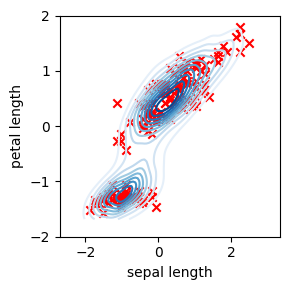

In [103]:
from scipy.stats import gaussian_kde

# Create a 2D Gaussian kernel density estimate
data = np.vstack(y_.transpose())
kde = gaussian_kde(data)
# Define grid points
x_grid = np.linspace(data[0].min(), data[0].max(), 100)
y_grid = np.linspace(data[1].min(), data[1].max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)

Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# Plot contour lines
plt.figure(figsize=(3,3))
plt.contour(X, Y, Z, levels=10, cmap='Blues')
plt.scatter(y_test[:,0], y_test[:,1], marker="x", color="r")
plt.xlabel("sepal length")
plt.ylabel("petal length")
plt.yticks([-2, -1, 0, 1, 2])
# plt.legend()
plt.tight_layout()